In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 

from collections import defaultdict
from itertools import product
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import utils_hiv as hiv

In [2]:
import os 
# os.chdir('/Users/lucblassel')

In [3]:
dirname = 'whole_dataset_figure_results_RAM'
if not os.path.isdir(dirname):
    os.makedirs(dirname)

In [4]:
models = ['RF', 'Bayes', 'Logistic', '1_minus_exact_p_value']
targets = ['encoded_label', 'hasDRM']

In [5]:
x_order = ['228_R', '228_H', '203_K', '135_L', '208_Y', '218_E']
x_labels = ['L228R', 'L228H', 'E203K', 'I135L', 'H208Y', 'D218E']
treatment_order = ['NRTI', 'NNRTI', 'Other']
all_order = ['ALL', 'DRMs', 'SDRMs'] + treatment_order
corresp = {k:v for k,v in zip(x_order, x_labels)}

In [6]:
DRM_names = hiv.DRM_utils.get_DRM_names()

In [7]:
coeffs_multi = pd.read_csv("../data/results/Alternate_target_results/coefs_df.tsv.gz", sep="\t", index_col=0, compression="gzip")
# coeffs_multi = pd.read_csv('whole_dataset_multi_targets/coefs_df.tsv', sep='\t', index_col=0)
# fisher_p_values = pd.read_csv('/Users/lucblassel/Documents/Work/utils_hiv/utils_hiv/utils/data/fisher_p_values.tsv', sep='\t', index_col=0)
fisher_p_values = pd.read_csv("../utils_hiv/utils_hiv/utils/data/fisher_p_values.tsv", sep="\t", index_col=0)

In [8]:
pivoted_p_values = pd.pivot_table(fisher_p_values[
    (fisher_p_values['DRMs'] == 'ALL') & 
    (fisher_p_values['seqs'] == 'None') & 
    (fisher_p_values['target'].isin(['encoded_label', 'hasDRM']))
].reset_index(), columns='index', index=['subtype', 'target'], values='p_value', aggfunc=lambda x: 1-x).reset_index()
for k,v in {'dir':'noDir','normalized':False, 'model':models[-1]}.items():
    pivoted_p_values[k] = v

In [9]:
concated_coeffs = pd.concat([coeffs_multi, pivoted_p_values], axis=0, sort=False)

In [10]:
concated_coeffs.to_csv(os.path.join(dirname, 'concated_coeffs.tsv'), sep='\t', index=True, header=True)

In [11]:
def get_rank(row):
    subtype, model = row.loc[['subtype', 'model']]
    col_name = f'{subtype}_{model}'
    return (row.filter(regex=r'\d+_\S')
                .sort_values(ascending=False)
                .reset_index()
                .rename({'index':'feature'}, axis=1)
                .reset_index()
                .rename({'index':col_name}, axis=1)
                .set_index('feature')
                [col_name])

In [12]:
subset_treatment_status = concated_coeffs[
    (concated_coeffs['dir'] != 'results_whole_training_set') & 
    (concated_coeffs['target'] == 'encoded_label') & 
    (concated_coeffs['model'].isin(models))
]

subset_hasDRM = concated_coeffs[
    (concated_coeffs['dir'] != 'results_whole_training_set') & 
    (concated_coeffs['target'] == 'hasDRM') & 
    (concated_coeffs['model'].isin(models))
]

In [13]:
to_concat = []
for _, row in subset_treatment_status.iterrows():
    to_concat.append(get_rank(row))
ranks_treatment_status = pd.concat(to_concat, axis=1)
ranks_treatment_status['average'] = ranks_treatment_status.mean(axis=1)
ranks_treatment_status['average_subtypes'] = ranks_treatment_status.filter(regex=r'(B|C)_.*', axis=1).mean(axis=1)

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [14]:
to_concat = []
for _, row in subset_hasDRM.iterrows():
    to_concat.append(get_rank(row))
ranks_hasDRM = pd.concat(to_concat, axis=1)
ranks_hasDRM['average'] = ranks_hasDRM.mean(axis=1)
ranks_hasDRM['average_subtypes'] = ranks_hasDRM.filter(regex=r'(B|C)_.*', axis=1).mean(axis=1)

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [15]:
ranks_treatment_status.to_csv(os.path.join(dirname, 'ranks_treatment_status.tsv'), sep='\t')
ranks_hasDRM.to_csv(os.path.join(dirname, 'ranks_hasDRM.tsv'), sep='\t')

sorted by average rank in models trained on treatment status task

In [16]:
ranks_treatment_status.sort_values(by='average_subtypes').iloc[:10]

,ALL_Bayes,B_Bayes,C_Bayes,ALL_Logistic,B_Logistic,C_Logistic,ALL_RF,B_RF,C_RF,ALL_1_minus_exact_p_value,B_1_minus_exact_p_value,C_1_minus_exact_p_value,average,average_subtypes
228_R,47,40,51,26,54,119,26,19,38,6,5,1,36.000000,40.875
203_K,45,44,46,85,111,132,35,32,39,1,6,0,48.000000,51.250
218_E,62,50,73,72,73,156,46,29,85,2,0,7,54.583333,59.125
228_H,48,39,57,132,124,184,42,30,68,3,2,5,61.166667,63.625
135_L,46,38,52,239,260,148,73,58,54,11,15,2,83.000000,78.375
165_L,96,88,99,130,149,112,109,94,91,13,13,6,83.333333,81.500
178_L,11,9,8,316,307,261,19,6,28,17,56,3,86.750000,84.750
139_K,88,96,64,168,207,151,99,98,64,14,24,4,89.750000,88.500
208_Y,56,42,100,145,133,266,63,37,143,5,1,15,83.833333,92.125
203_D,33,24,43,281,238,293,54,49,45,12,9,47,94.000000,93.500


sorted by average rank in models trained on has DRM or not task

In [17]:
ranks_hasDRM.sort_values(by='average_subtypes').iloc[:10]

,ALL_Bayes,B_Bayes,C_Bayes,ALL_Logistic,B_Logistic,C_Logistic,ALL_RF,B_RF,C_RF,ALL_1_minus_exact_p_value,B_1_minus_exact_p_value,C_1_minus_exact_p_value,average,average_subtypes
228_R,53,56,57,9,5,0,33,32,35,17,0,11,25.666667,24.500
203_K,52,59,47,83,58,7,41,51,32,26,2,7,38.750000,32.875
214_L,1,3,2,265,296,24,0,3,0,29,6,9,53.166667,42.875
218_E,79,74,76,73,22,30,56,58,67,0,11,22,47.333333,45.000
228_H,50,49,62,179,79,110,45,35,62,5,5,28,59.083333,53.750
223_Q,67,47,135,2,2,12,78,61,189,21,3,40,54.750000,61.125
135_L,45,38,56,272,300,10,52,60,42,12,29,13,77.416667,68.500
122_P,19,14,66,196,182,162,2,1,69,3,7,68,65.750000,71.125
139_R,68,52,119,137,125,40,83,72,109,2,20,46,72.750000,72.875
208_Y,70,57,98,144,141,76,67,56,116,27,10,37,74.916667,73.875


In [18]:
common_features = set(ranks_treatment_status.sort_values(by='average_subtypes').iloc[:10].index) & set(ranks_hasDRM.sort_values(by='average_subtypes').iloc[:10].index)

In [19]:
pd.concat([ranks_treatment_status.sort_values(by='average_subtypes').iloc[:10].reset_index().reset_index(drop=False).set_index('index')['level_0'].rename('rank_treatment'),
ranks_hasDRM.sort_values(by='average_subtypes').iloc[:10].reset_index().reset_index(drop=False).set_index('index')['level_0'].rename('rank_DRM')], axis=1).loc[common_features].sort_values(by=['rank_treatment', 'rank_DRM']).astype(int)

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,rank_treatment,rank_DRM
228_R,0,0
203_K,1,1
218_E,2,3
228_H,3,4
135_L,4,6
208_Y,8,9


## Ratios

In [20]:
drms = {
    'ALL': set(hiv.DRM_utils.get_all_DRMs()), 
    'DRMs': set(hiv.DRM_utils.get_DRMs_only()),
    'SDRMs': set(hiv.DRM_utils.get_SDRMs()),
    'NRTI': set(hiv.DRM_utils.get_NRTI()),
    'NNRTI': set(hiv.DRM_utils.get_NNRTI()),
    'Other': set(hiv.DRM_utils.get_Other())
}

In [21]:
uk_data = pd.read_csv('/Users/lucblassel/Work/hiv-drm-detection/data_pre_split/uk-data-with-scores.tsv.homo', sep='\t', index_col=0)

In [22]:
africa_data = pd.read_csv('/Users/lucblassel/Work/hiv-drm-detection/data_pre_split/africa-data-with-scores.tsv.homo', sep='\t', index_col=0)

In [23]:
def get_ratios(data, mut, prevalence=False):
    freqs = (
        data.filter(list(common_features) + [mut], axis=1)
        .groupby(mut)
        .apply(lambda x: x.apply(
            lambda y: y.value_counts(normalize=True).get(1,0)
            )
        ).filter(common_features)
        .reindex([0,1])
        .fillna(0)
    )
    if prevalence: 
        return freqs.loc[1].rename(mut)
        
    return (freqs.loc[1] / freqs.loc[0]).rename(mut)

In [24]:
def get_contingency(v1, v2):
    return np.bincount(2 * v1 + v2, minlength=4).reshape(2,2)
def compute_ratio(contingency):
    return (contingency[1,1] / contingency[:,1].sum()) / (contingency[1,0] / contingency[:,0].sum())
def compute_prevalence(contingency):
    return contingency[1,1] / contingency[:,1].sum()
def compute_cooccurrence_prop(contingency):
    return contingency[1,1] / contingency[1,:].sum()
def compute_weighted_cooccurrence_prop(contingency):
    return (contingency[1,1] / contingency[:, 1].sum()) / ( 
    (contingency[1,1] / contingency[:, 1].sum()) + 
    (contingency[1,0] / contingency[:, 0].sum())
)

In [25]:
def numpy_version(subset, mut, func):
    """subset columns must be ordered by common_features, and lastly the DRM"""
    results = dict()
    for i, new_mut in enumerate(common_features):
        contingency = get_contingency(subset[:,i], subset[:,-1])
        results[new_mut] = func(contingency)
    return results

In [26]:
def get_prevalence_proportion(data, mut):
    proportions = {}
    for new_mut in common_features:
        tab = pd.crosstab(data[new_mut], data[mut])
        proportions[new_mut] = tab.iloc[1,1] / tab.iloc[1].sum()
        
    return pd.Series(proportions, name=mut)

In [27]:
def get_inter_count(data, mut):
    counts = (
        data.filter(list(common_features) + [mut], axis=1)
        .groupby(mut)
        .apply(lambda x: x.apply(
            lambda y: y.value_counts().get(1,0)
            )
        ).filter(common_features)
        .reindex([0,1])
        .fillna(0)
    )

    return counts.loc[1].rename(mut)

In [28]:
for key, muts in drms.items():
    uk_data[key] = uk_data.filter(muts, axis=1).any(axis=1).astype(int)

In [29]:
for key, muts in drms.items():
    africa_data[key] = africa_data.filter(muts, axis=1).any(axis=1).astype(int)

In [30]:
drm_counts = pd.concat(
    [
        africa_data.filter(drms['ALL'], axis=1).sum().rename('Africa'),
        uk_data.filter(drms['ALL'], axis=1).sum().rename('UK')
    ], axis=1)

In [31]:
new_counts = pd.concat(
    [
        africa_data.filter(common_features, axis=1).sum().rename('Africa'),
        uk_data.filter(common_features, axis=1).sum().rename('UK')
    ], axis=1)

In [32]:
to_concat = []
cols = set(uk_data.columns.tolist())
for mut in list(drms['ALL']) + list(drms.keys()) + targets:
    if mut not in cols:
        continue
    to_concat.append(get_ratios(uk_data, mut))
drm_ratios = pd.concat(to_concat, axis=1)
drm_ratios

,132_L,181_I,70_N,101_Q,74_V,106_M,230_I,179_F,75_A,100_I,...,190_R,188_C,ALL,DRMs,SDRMs,NRTI,NNRTI,Other,encoded_label,hasDRM
228_R,39.135338,12.282965,0.000000,4.106706,14.064663,7.780831,0.0,61.701111,0.000000,28.014662,...,0.0,5.115321,115.676157,5.929160,282.863650,73.616500,26.971166,3.446145,18.096979,115.676157
218_E,35.206088,16.622455,0.000000,3.147998,20.924271,8.442202,0.0,41.565120,33.445181,24.125835,...,0.0,0.000000,26.973812,4.635907,56.587720,61.419257,7.535879,4.051662,13.082997,26.973812
208_Y,14.324045,0.000000,27.220098,3.226698,28.873156,2.507585,0.0,173.534375,41.226980,17.308551,...,0.0,0.000000,14.939342,8.607935,25.483212,35.327777,6.202160,6.494513,8.828482,14.939342
203_K,0.000000,32.916403,0.000000,2.048697,18.688772,7.580753,0.0,54.656496,44.062698,15.530396,...,0.0,0.000000,20.057450,3.821694,47.993382,49.126432,7.313922,3.223514,10.994115,20.057450
228_H,10.217151,9.706119,19.415734,7.117716,14.092653,1.783564,0.0,48.711404,9.706119,20.222263,...,0.0,4.042177,9.160917,4.504864,19.381598,18.769091,7.742585,5.170006,6.421509,9.160917
135_L,0.000000,5.150186,0.000000,0.721050,2.989182,1.897124,0.0,0.000000,0.000000,2.381135,...,0.0,6.458450,2.353750,1.748419,3.238788,3.311359,2.311003,1.564736,1.796458,2.353750


In [33]:
to_concat = []
cols = set(africa_data.columns.tolist())
for mut in list(drms['ALL']) + list(drms.keys()) + targets:
    if mut not in cols:
        continue
    to_concat.append(get_ratios(africa_data, mut))
drm_ratios_africa = pd.concat(to_concat, axis=1)
drm_ratios_africa

,132_L,181_I,70_N,101_Q,74_V,106_M,230_I,179_F,75_A,100_I,...,190_R,188_C,ALL,DRMs,SDRMs,NRTI,NNRTI,Other,encoded_label,hasDRM
228_R,3.786603,10.369792,8.216495,0.642612,5.174479,11.248582,0.0,20.556701,10.273196,12.568421,...,0.0,0.0,42.395467,4.516623,61.718404,33.415671,53.532254,3.216766,32.512545,42.395467
218_E,0.000000,0.000000,33.208333,0.000000,0.000000,7.186594,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,inf,18.401055,inf,inf,inf,4.166892,inf,inf
208_Y,0.000000,0.000000,0.000000,11.333333,20.697917,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,inf,30.110818,inf,inf,inf,8.485308,inf,inf
203_K,4.441077,0.000000,0.000000,4.794872,14.058962,6.388084,0.0,0.000000,0.000000,7.236364,...,0.0,0.0,17.404455,6.273087,19.879823,18.160691,17.243021,4.596209,14.111828,17.404455
228_H,2.305944,9.572115,0.000000,3.740000,14.902500,6.763853,0.0,0.000000,19.163462,0.000000,...,0.0,0.0,34.139508,12.267370,32.483370,26.696215,28.174871,8.081246,23.058542,34.139508
135_L,0.901572,0.000000,0.000000,0.944444,3.763258,1.296829,0.0,0.000000,0.000000,2.992481,...,0.0,0.0,2.398691,1.801502,3.171906,2.943944,2.665776,1.216357,2.560970,2.398691


In [34]:
def get_valid_muts(counts, country, n_sequences):
    threshold = n_sequences * 1e-3 if country == 'UK' else 30
    return counts[country][
        counts[country] > threshold
    ].index.tolist()

In [35]:
def get_drm_type(mut):
    for key, muts in drms.items():
        if key not in ['NRTI', 'NNRTI', 'Other']:
            continue
        if mut in muts:
            return key
    return "New"

In [36]:
uk_valid_drms = get_valid_muts(drm_counts, 'UK', uk_data.shape[0])
africa_valid_drms = get_valid_muts(drm_counts, 'Africa', africa_data.shape[0])

In [37]:
uk_valid_new = get_valid_muts(new_counts, 'UK', uk_data.shape[0])
africa_valid_new = get_valid_muts(new_counts, 'Africa', africa_data.shape[0])

In [38]:
subset_ratio = drm_ratios.filter(uk_valid_drms, axis=1).filter(uk_valid_new, axis=0)
subset_melted = pd.melt(subset_ratio.reset_index(), id_vars='index')
subset_melted['group'] = subset_melted['variable'].apply(get_drm_type)

In [39]:
subset_ratio_africa = drm_ratios_africa.filter(africa_valid_drms, axis=1).filter(africa_valid_new, axis=0)
subset_melted_africa = pd.melt(subset_ratio_africa.reset_index(), id_vars='index')
subset_melted_africa['group'] = subset_melted_africa['variable'].apply(get_drm_type)

# Detailed ratio figures in Africa

In [40]:
to_concat = []
cols = set(africa_data.columns.tolist())
for mut in list(drms['ALL']) + list(drms.keys()) + targets:
    if mut not in cols:
        continue
    to_concat.append(get_ratios(africa_data, mut, True))
positive_prevalence_africa = pd.concat(to_concat, axis=1)

subset_prevalence_africa = positive_prevalence_africa.filter(africa_valid_drms, axis=1).filter(africa_valid_new, axis=0)
prevalence_melted_africa = pd.melt(subset_prevalence_africa.reset_index(), id_vars='index')
prevalence_melted_africa['group'] = prevalence_melted_africa['variable'].apply(get_drm_type)

In [41]:
to_concat = []
cols = set(africa_data.columns.tolist())
for mut in list(drms['ALL']) + list(drms.keys()) + targets:
    if mut not in cols:
        continue
    to_concat.append(get_inter_count(africa_data, mut))
positive_counts_africa = pd.concat(to_concat, axis=1)

subset_counts_africa = positive_counts_africa.filter(africa_valid_drms, axis=1).filter(africa_valid_new, axis=0)
counts_melted_africa = pd.melt(subset_counts_africa.reset_index(), id_vars='index')
counts_melted_africa['group'] = counts_melted_africa['variable'].apply(get_drm_type)

In [42]:
shapes = [africa_data.shape[0], uk_data.shape[0]]
drm_prevs = drm_counts / shapes

In [43]:
indexer = ['index', 'variable', 'group']
all_melted_africa = pd.concat([
    subset_melted_africa.set_index(indexer),
    prevalence_melted_africa.set_index(indexer).rename({'value':'positive prevalence'}, axis=1),
    counts_melted_africa.set_index(indexer).rename({'value':'count'}, axis=1)
], axis=1).reset_index()
all_melted_africa['drm prevalence'] = all_melted_africa['variable'].apply(lambda x: drm_prevs['Africa'].loc[x])

# Detailed ratio figures for UK

In [44]:
to_concat = []
cols = set(uk_data.columns.tolist())
for mut in list(drms['ALL']) + list(drms.keys()) + targets:
    if mut not in cols:
        continue
    to_concat.append(get_ratios(uk_data, mut, True))
positive_prevalence_uk = pd.concat(to_concat, axis=1)

subset_prevalence_uk = positive_prevalence_uk.filter(uk_valid_drms, axis=1).filter(uk_valid_new, axis=0)
prevalence_melted_uk = pd.melt(subset_prevalence_uk.reset_index(), id_vars='index')
prevalence_melted_uk['group'] = prevalence_melted_uk['variable'].apply(get_drm_type)

In [45]:
to_concat = []
cols = set(uk_data.columns.tolist())
for mut in list(drms['ALL']) + list(drms.keys()) + targets:
    if mut not in cols:
        continue
    to_concat.append(get_inter_count(uk_data, mut))
positive_counts_uk = pd.concat(to_concat, axis=1)

subset_counts_uk = positive_counts_uk.filter(uk_valid_drms, axis=1).filter(uk_valid_new, axis=0)
counts_melted_uk = pd.melt(subset_counts_uk.reset_index(), id_vars='index')
counts_melted_uk['group'] = counts_melted_uk['variable'].apply(get_drm_type)

In [46]:
indexer = ['index', 'variable', 'group']
all_melted_uk = pd.concat([
    subset_melted.set_index(indexer),
    prevalence_melted_uk.set_index(indexer).rename({'value':'positive prevalence'}, axis=1),
    counts_melted_uk.set_index(indexer).rename({'value':'count'}, axis=1)
], axis=1).reset_index()
all_melted_uk['drm prevalence'] = all_melted_uk['variable'].apply(lambda x: drm_prevs['UK'].loc[x])

# Confidence intervals

In [47]:
def get_CI_numpy(data, mut, n_boot=1000, level=0.95, func=compute_ratio):
    onesided = (1 - level) / 2
    open_index, close_index = round(n_boot * onesided), round(n_boot * (1 - onesided))
    boostrap_estimates = []
    subset = data.filter(list(common_features) + [mut], axis=1)
    ratios = numpy_version(subset.values, mut, func)
    for i in range(n_boot):
        boostrap_samples = subset.sample(frac=1, replace=True)
        boostrap_estimates.append(
            numpy_version(boostrap_samples.values, mut, func)
        )
    total_res = defaultdict(list)
    for l in boostrap_estimates:
        for k,v in l.items():
            total_res[k].append(v)

    subsetter = lambda x: (x[open_index], x[close_index])
    return {k:(ratios[k], subsetter(sorted(v))) for k,v in total_res.items()}

The computation of CIs is a very resource intensive process, The `DRM_ratio` files needed are included in the results

In [48]:
# melted_CIs_africa = pd.melt(
#     drm_ratio_CIs_africa
#         .filter(africa_valid_drms, axis=1)
#         .filter(africa_valid_new, axis=0)
#         .reset_index(), 
#     id_vars='index')
# melted_CIs_africa['ratio'] = melted_CIs_africa['value'].apply(lambda x: x[0])
# melted_CIs_africa['lower'] = melted_CIs_africa['value'].apply(lambda x: x[1][0]) 
# melted_CIs_africa['higher'] = melted_CIs_africa['value'].apply(lambda x: x[1][1])
# melted_CIs_africa['group'] = melted_CIs_africa['variable'].apply(get_drm_type)

In [49]:
# to_concat = []
# for name, df in {'UK':melted_CIs, 'Africa':melted_CIs_africa}.items():
#     sub = df.drop('value', axis=1)
#     sub['dataset'] = name
#     to_concat.append(sub)
# pd.concat(to_concat).to_csv(os.path.join(dirname, 'DRM_ratios.tsv'), sep='\t')

In [50]:
# concated_joined_ratios.to_csv(os.path.join(dirname, "DRM_ratios.tsv"), sep="\t", index=True, header=True)
# drm_ratio_CIs.to_csv(os.path.join(dirname, "DRM_ratio_CIs.tsv"), sep="\t", index=True, header=True)
# drm_ratio_CIs_africa.to_csv(os.path.join(dirname, "DRM_ratio_CIs_africa.tsv"), sep="\t", index=True, header=True)

In [51]:
concated_joined_ratios = pd.read_csv(os.path.join(dirname, 'DRM_ratios.tsv'), sep='\t', index_col=0).drop_duplicates()
# concated_joined_ratios = pd.read_csv("/Users/lucblassel/coefficient_rankings_multi_target/DRM_ratios.tsv", sep='\t', index_col=0).drop_duplicates()
melted_CIs = concated_joined_ratios[concated_joined_ratios['dataset'] == 'UK']
melted_CIs_africa = concated_joined_ratios[concated_joined_ratios['dataset'] == 'Africa']
drm_ratio_CIs = pd.read_csv(os.path.join(dirname, 'DRM_ratio_CIs.tsv'), sep='\t')
drm_ratio_CIs_africa = pd.read_csv(os.path.join(dirname, 'DRM_ratio_CIs_africa.tsv'), sep='\t')
# drm_ratio_CIs = pd.read_csv('/Users/lucblassel/coefficient_rankings_multi_target/DRM_ratio_CIs.tsv', sep='\t')
# drm_ratio_CIs_africa = pd.read_csv('/Users/lucblassel/coefficient_rankings_multi_target/DRM_ratio_CIs_africa.tsv', sep='\t')

In [52]:
LOWER_CUTOFF = 4

In [53]:
def plot_vlines(**kwargs):
    data = (kwargs.pop('data').sort_values(by='lower', ascending=False)
                .reset_index(drop=True)
                .reset_index()
                .rename({'level_0': 'x'}, axis=1))
    annotate = kwargs.pop('annotate', True)
    font_dict = kwargs.pop('font_kws', dict(verticalalignment='bottom', horizontalalignment='left'))
    lower_bound = kwargs.pop('lower_bound', 5)
    text_y_offset = kwargs.pop('text_y_offset', 5)
    max_posy = kwargs.pop('max_posy', 180)
    size = kwargs.pop('size', 60)
    kwargs.pop('color', None)
    colors = sns.color_palette('muted')
    hue_order = ['NRTI', 'NNRTI', 'Other']
    markers = ['o', 's', 'D']

    # Deal with infinite ratios:
    for colname in ['ratio', 'higher', 'lower']:
        data[colname] = data[colname].apply(lambda x: max_posy if np.isinf(x) else x)

    ax = sns.scatterplot(data=data, x='x', y='ratio', hue='group', style='group', style_order=hue_order, markers=markers, 
                         edgecolor='k', zorder=1, hue_order=hue_order, s=size)
    ax.vlines(data['x'], data['lower'], data['higher'], zorder=0.9)
    if not annotate: return ax
    for _, row in data.iterrows():
        if row['lower'] < lower_bound: continue
        ax.text(row['x'], row['higher'] + text_y_offset, row['variable'].replace('_',''), rotation=90, **font_dict)
    return ax

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


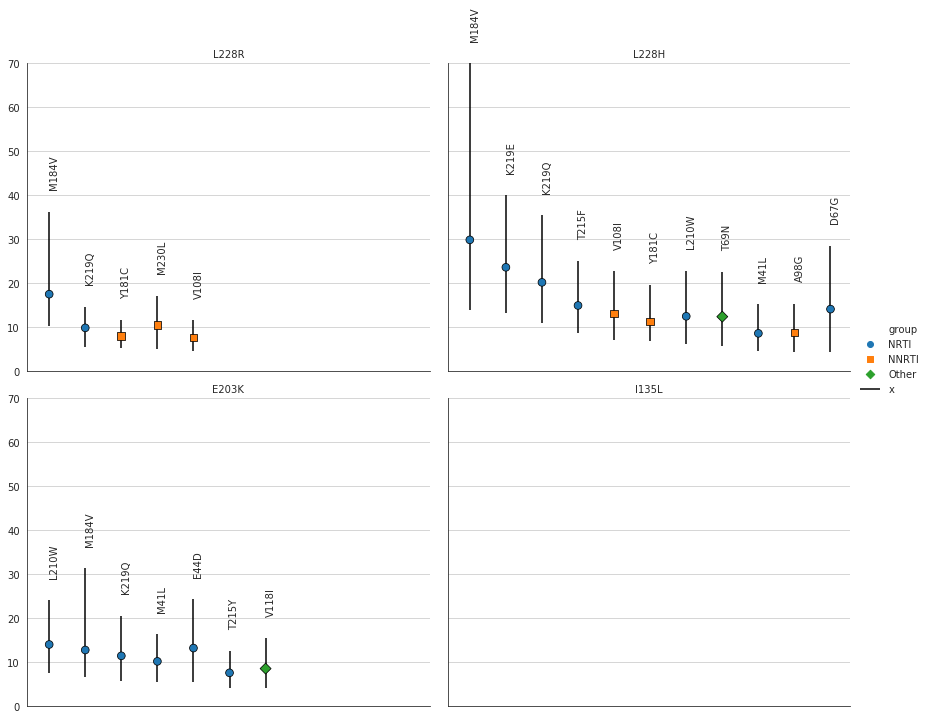

In [54]:
to_plot = melted_CIs_africa[
    (melted_CIs_africa['variable'].isin(drms['ALL'])) & 
    (melted_CIs_africa['lower'] > LOWER_CUTOFF)
]
to_plot['index'] = to_plot['index'].apply(corresp.get)
to_plot['variable'] = to_plot['variable'].apply(DRM_names.get)

to_plot.to_csv(os.path.join(dirname, "Fig_S2.csv"), index=True, header=True)

with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True}):
    grid = (sns.FacetGrid(data=to_plot, col='index', sharex=True, height=5, col_wrap=2, aspect=1.2, 
                            col_order=x_labels[:4])
                .map_dataframe(plot_vlines, max_posy=70, lower_bound=2)
                .set(ylim=(0,70))
                .set_titles(template="{col_name}")
                .add_legend()
                )
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.xaxis.grid(False)
grid.savefig(os.path.join(dirname, "Africa_ratio_bars.pdf"), format='pdf', alpha=.99, bbox_inches='tight')
grid.savefig(os.path.join(dirname, "Africa_ratio_bars.eps"), format='eps', alpha=.99, bbox_inches='tight')
plt.show()

In [55]:
sns.set_context("notebook")

In [56]:
for name in ['NRTI', 'NNRTI', 'Other']:
    print(name)
    print(
        pd.concat([
            uk_data.filter(drms[name], axis=1).any(axis=1).value_counts(normalize=True).rename('UK'),
            africa_data.filter(drms[name], axis=1).any(axis=1).value_counts(normalize=True).rename('Africa')
        ], axis=1)
    )
    print()

NRTI
             UK    Africa
False  0.892472  0.685464
True   0.107528  0.314536

NNRTI
             UK    Africa
False  0.840058  0.628321
True   0.159942  0.371679

Other
             UK    Africa
False  0.827239  0.841353
True   0.172761  0.158647



/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


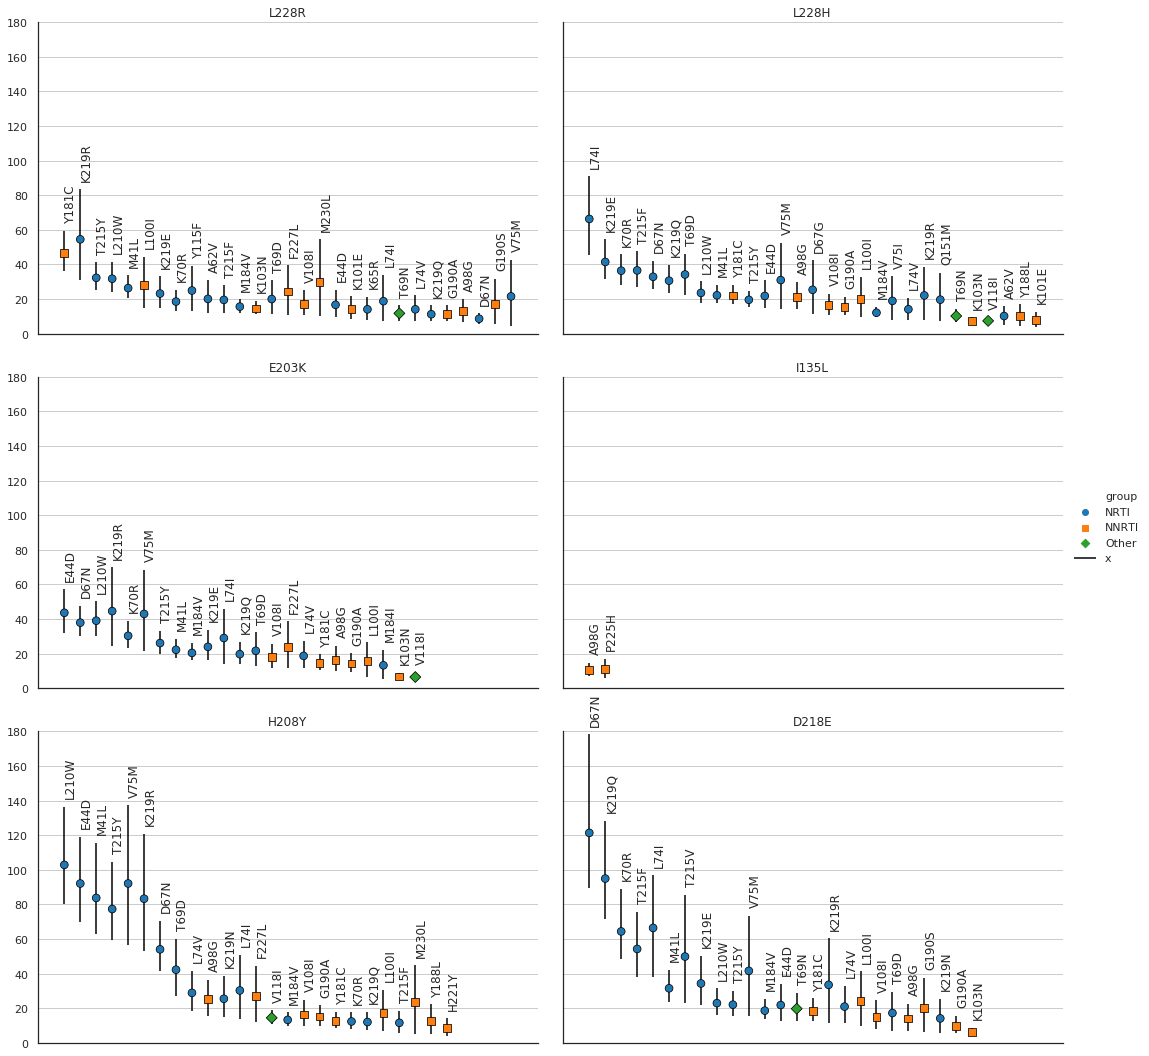

In [57]:
to_plot = melted_CIs[
    (melted_CIs['variable'].isin(drms['ALL'])) & 
    (melted_CIs['lower'] > 4)
]
to_plot['index'] = to_plot['index'].apply(corresp.get)
to_plot['variable'] = to_plot['variable'].apply(DRM_names.get)

to_plot.to_csv(os.path.join(dirname, "Fig_3.csv"), index=True, header=True)

with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True}):
    grid = (sns.FacetGrid(data=to_plot, col='index', sharex=True, height=5, col_wrap=2, aspect=1.5, col_order=x_labels)
                .map_dataframe(plot_vlines, lower_bound=2)
                .add_legend()
                .set_titles(template="{col_name}")
                .set(ylim=(0, 180))
                )
for ax in grid.axes.flatten():
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.xaxis.grid(False)

grid.savefig(os.path.join(dirname, "UK_ratio_bars.pdf"), format='pdf', alpha=.99, bbox_inches='tight')
plt.show()

In [58]:
tops = (concated_joined_ratios
        .groupby(['index', 'dataset'])
        .apply(lambda x: x.sort_values(by=['lower', 'ratio'], ascending=False).iloc[:5]['variable'].values)
        .reset_index())

In [59]:
tops[tops['dataset']=='UK']

,index,dataset,0
1,135_L,UK,"[98_G, 225_H, 184_V, 138_G, 103_N]"
3,203_K,UK,"[44_D, 67_N, 210_W, 219_R, 70_R]"
4,208_Y,UK,"[210_W, 44_D, 41_L, 215_Y, 75_M]"
5,218_E,UK,"[67_N, 219_Q, 70_R, 215_F, 74_I]"
7,228_H,UK,"[74_I, 219_E, 70_R, 215_F, 67_N]"
9,228_R,UK,"[181_C, 219_R, 215_Y, 210_W, 41_L]"


In [60]:
(uk_data
    .filter(drms['ALL'], axis=1)
    .apply(lambda x: x.value_counts(normalize=True).get(1,0) * 100)
    .apply(lambda x: f"{x:.1f}%")
    .sort_values(ascending=False)
    .iloc[:30])

68_G     5.3%
184_V    4.9%
138_A    4.6%
179_I    4.4%
118_I    4.4%
103_N    4.4%
90_I     3.3%
41_L     2.8%
215_Y    2.1%
67_N     2.1%
181_C    1.6%
103_R    1.5%
70_R     1.4%
179_D    1.4%
210_W    1.3%
106_I    1.3%
69_N     1.1%
190_A    1.0%
219_Q    1.0%
215_D    0.8%
101_Q    0.8%
221_Y    0.8%
108_I    0.7%
103_Q    0.7%
69_A     0.6%
65_R     0.6%
101_E    0.6%
215_S    0.6%
106_M    0.6%
215_F    0.6%
dtype: object

In [61]:
all_tops = concated_joined_ratios.sort_values(by='lower', ascending=False).iloc[:30]
print(all_tops['index'].value_counts())
print(all_tops['variable'].value_counts())

208_Y    8
218_E    7
228_H    6
203_K    5
228_R    4
Name: index, dtype: int64
67_N     4
70_R     3
210_W    3
219_R    3
215_Y    2
41_L     2
74_I     2
219_Q    2
44_D     2
215_F    2
219_E    1
75_M     1
69_D     1
215_V    1
181_C    1
Name: variable, dtype: int64
